In [1]:
import numpy as np
import tensorflow as tf
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## **1. LOAD DATASET**

In [2]:
#Load the data
df = pd.read_csv('heart_disease_health_indicators_BRFSS2015.csv')

#Display the first 5 rows of the data
df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


## **2. DATA VISUALIZATION**

#### 2.1 General overview of the data (number of samples, features, data types, missing values)

In [ ]:
print("Number of samples:", df.shape[0])
print("Number of features:", df.shape[1])
print("Data Types:\n", df.dtypes)
print("Missing Values:\n", df.isnull().sum())



Dataset Shape: (253680, 22)
Data Types:
 HeartDiseaseorAttack    float64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
Diabetes                float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
dtype: object
Missing Values:
 HeartDiseaseorAttack    0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
Diabetes                0
PhysActivity    

*We have more than 250k records, and 22 features giving information a bout each of them.* 

*All of our variables are numerical, there are no categorical features, which is an important thing to consider for later, when working with our dataset. Also there aren't any NULL values or missing values in any of the features for all records, which really eases up the process of data cleaning since there are no special cases to handle (imputing missing values with mean/median, dropping columns, etc.)*

#### 2.2 Distribution of our target variable

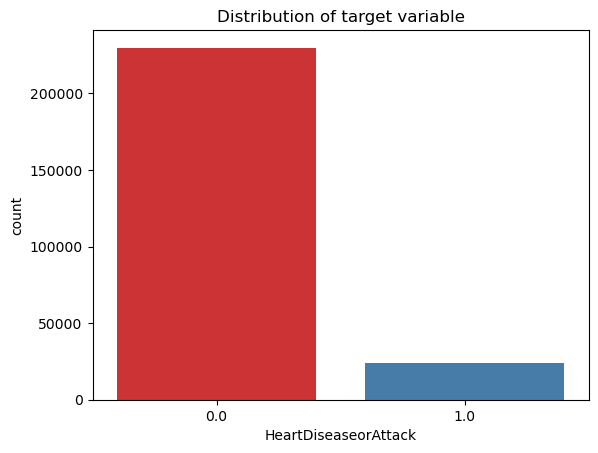

In [ ]:
sns.countplot(x=df['HeartDiseaseorAttack'], palette='Set1', hue=df['HeartDiseaseorAttack'], legend=False)
plt.title("Distribution of target variable")
plt.show()

*We observe a high imbalance in the target variable classes, meaning that our dataset contains much more samples for people that didn't have a heart disease or attack than for people who actually did. Later on we will need to handle this class imbalance properly to ensure our models work properly.*


#### 2.3 Histograms and boxplots of numerical features (all features in our case)

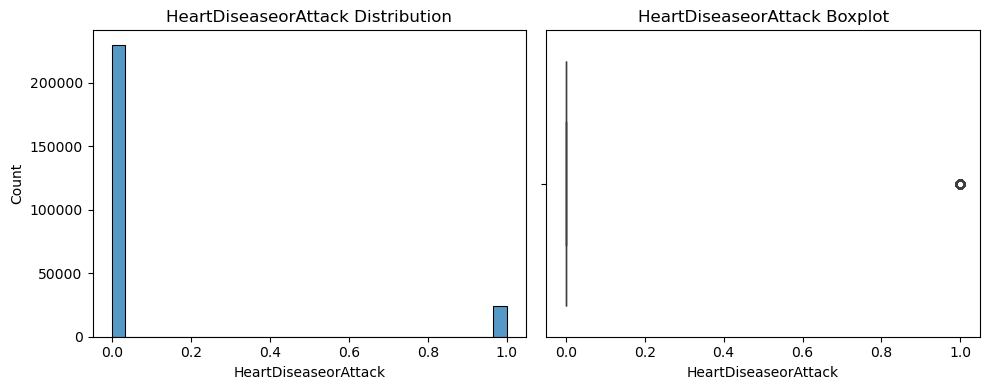

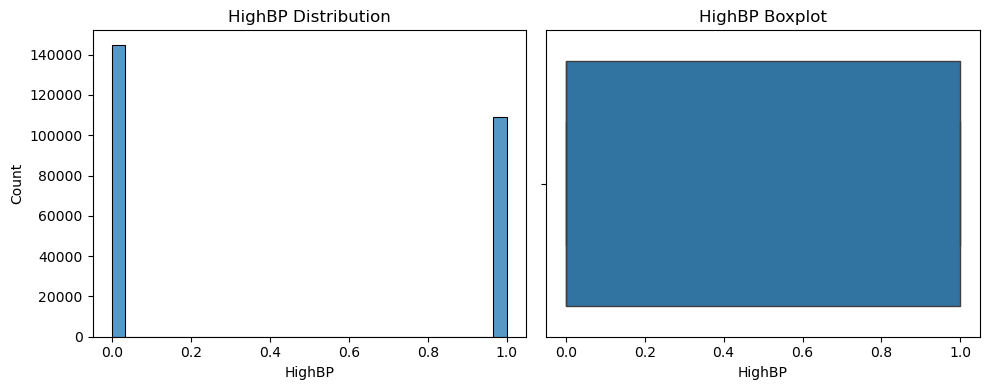

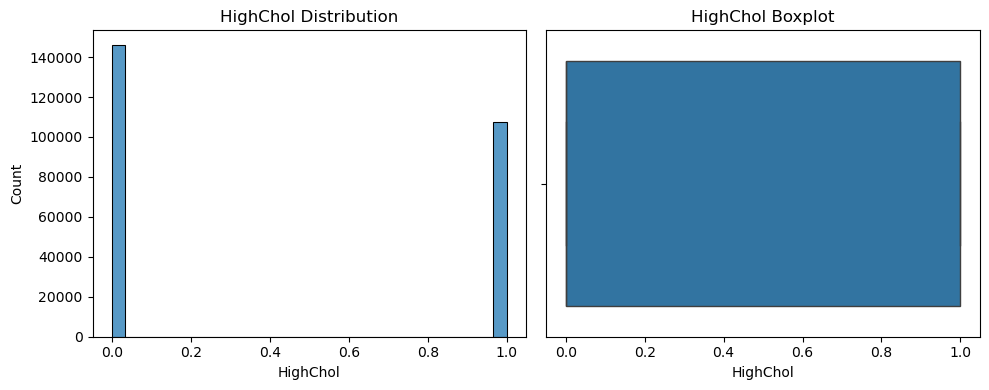

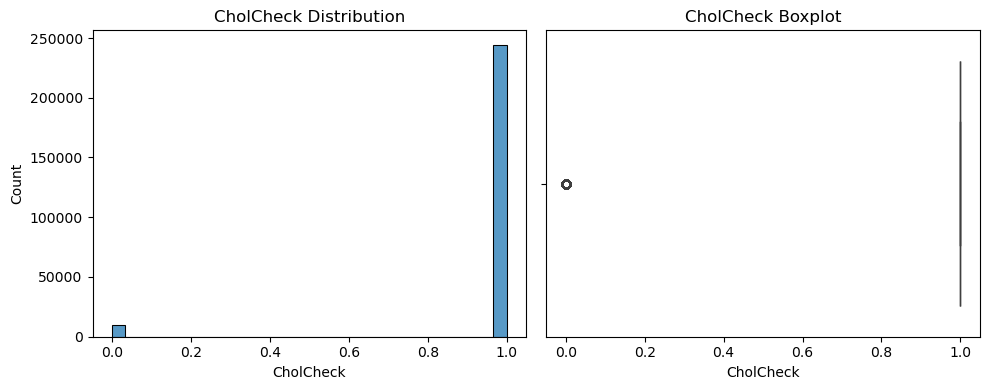

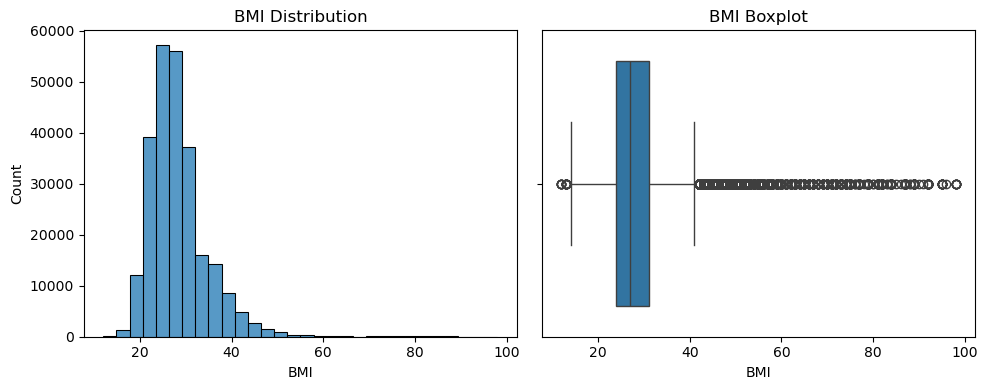

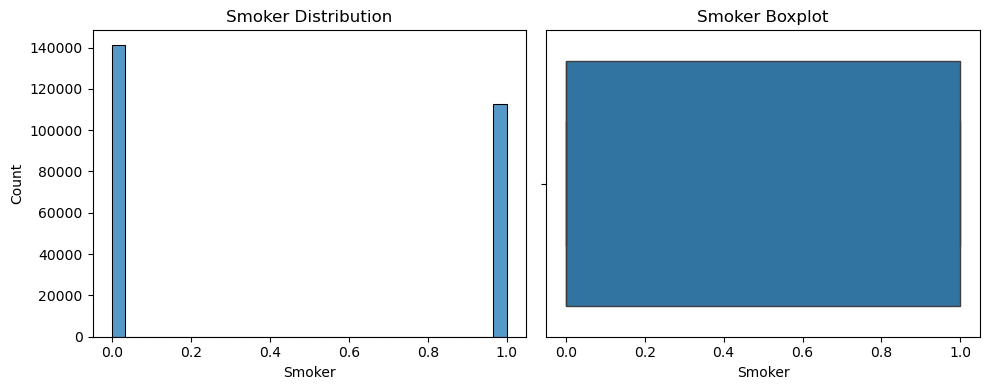

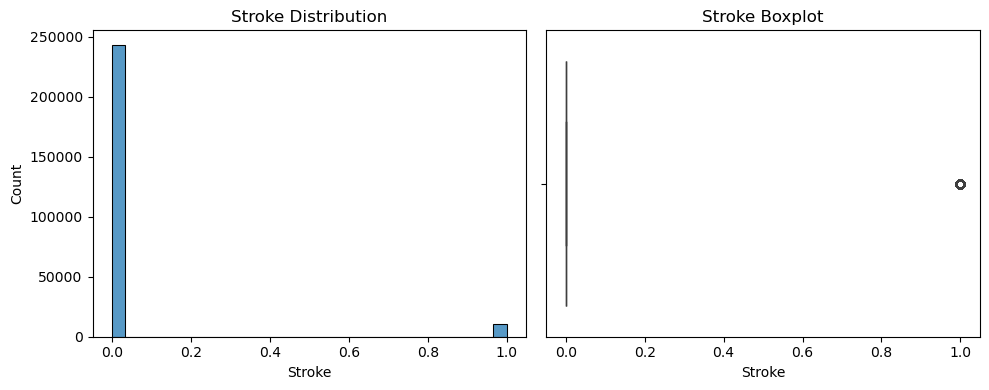

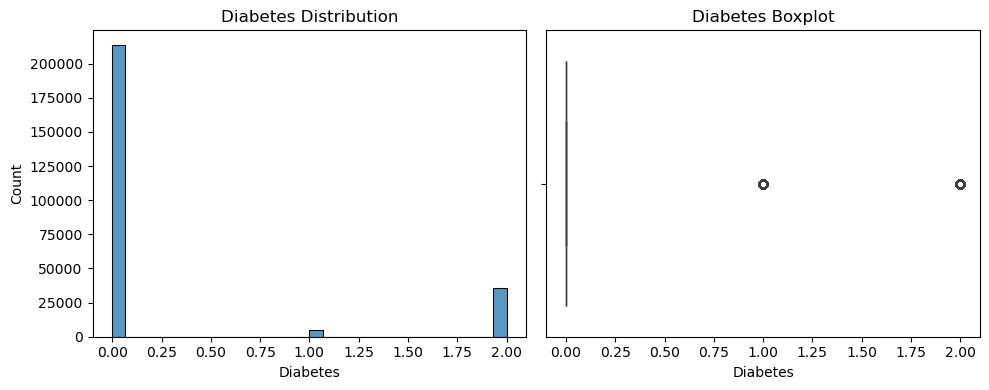

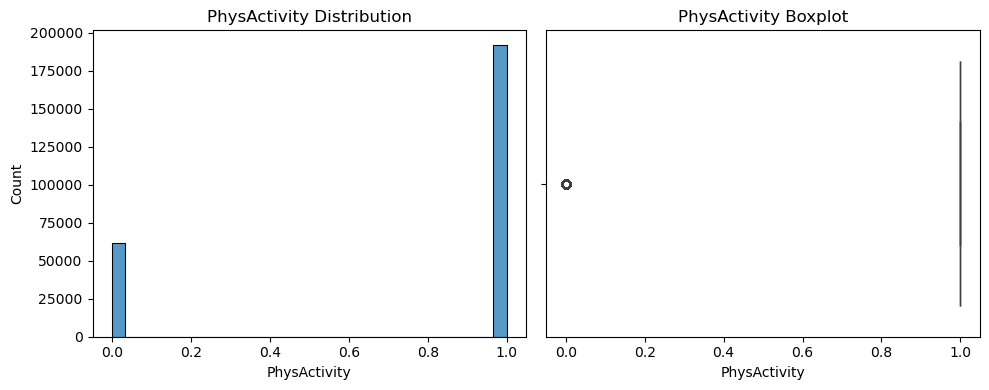

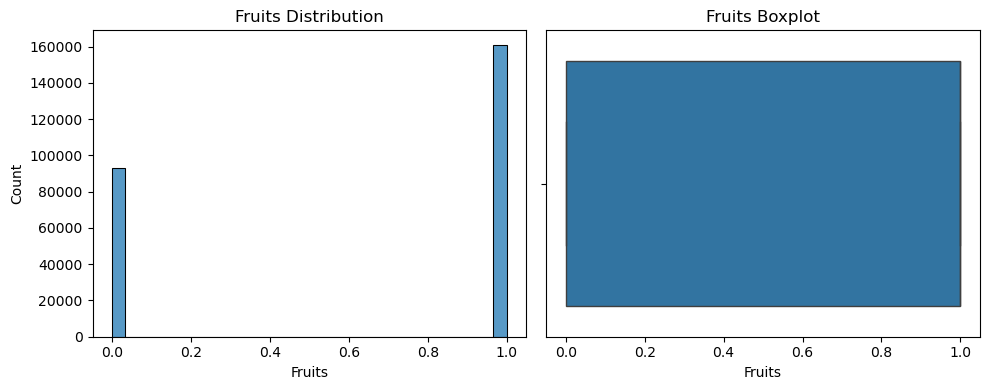

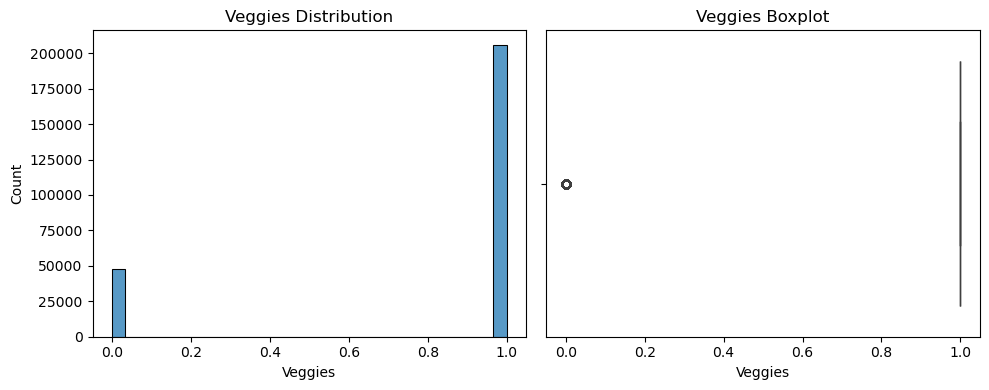

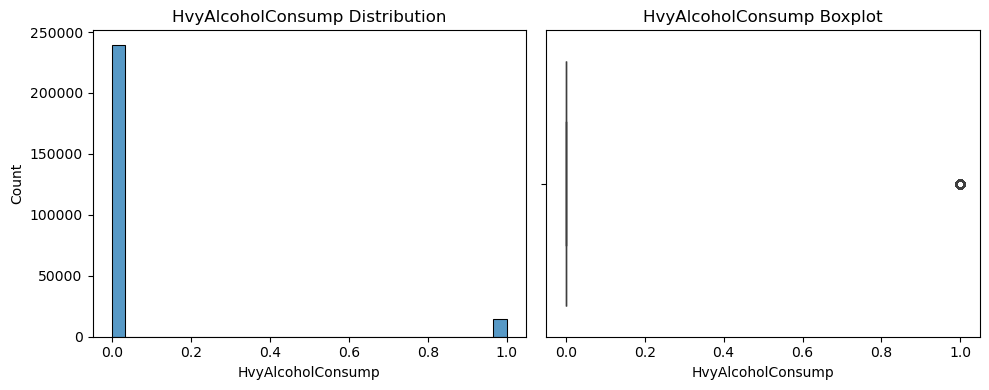

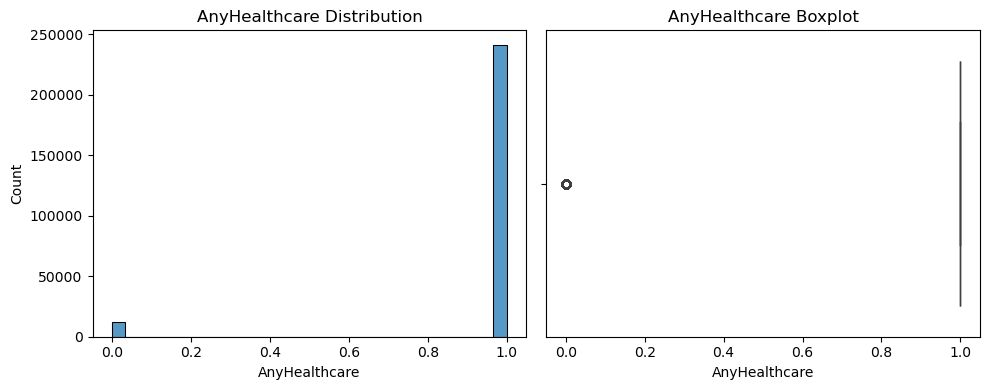

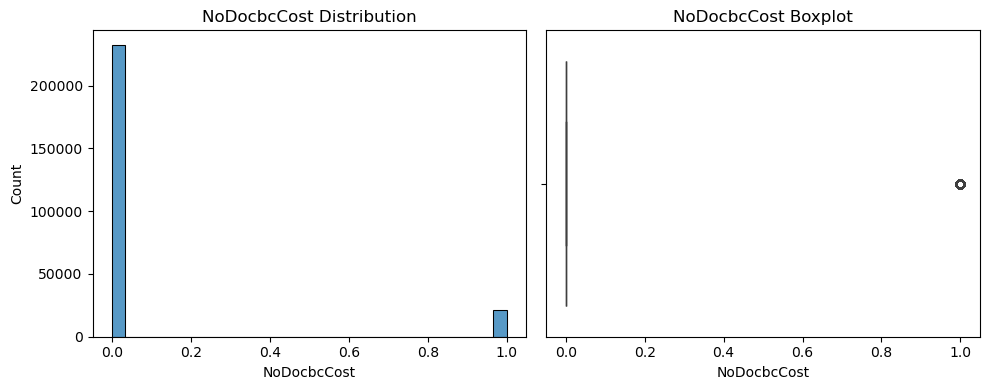

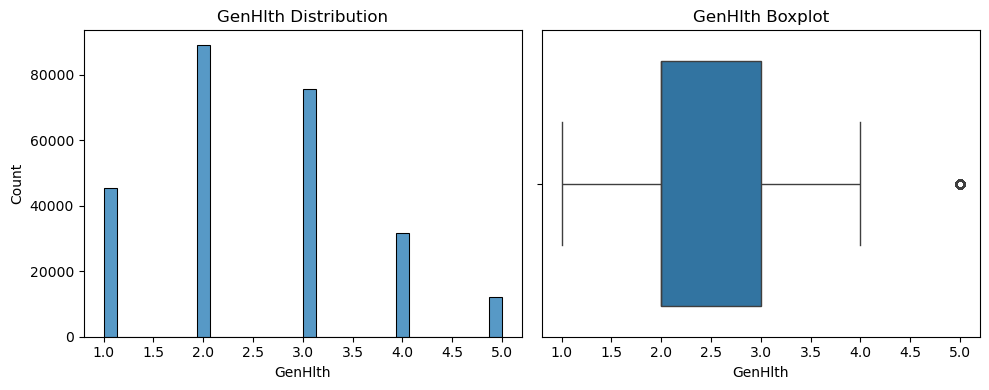

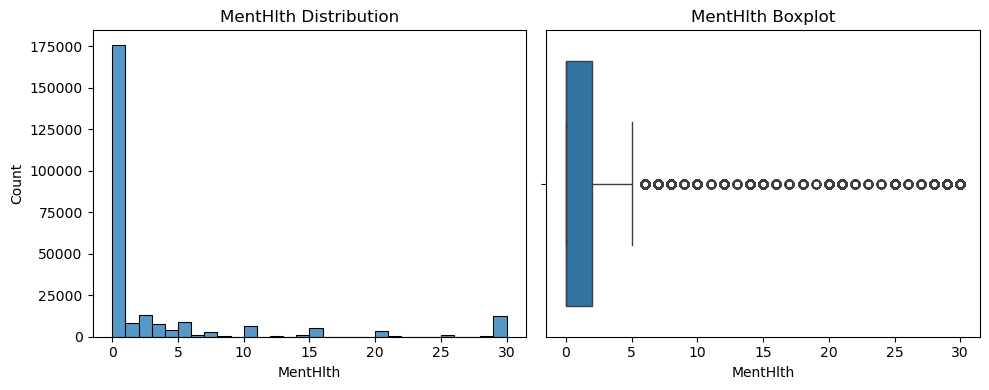

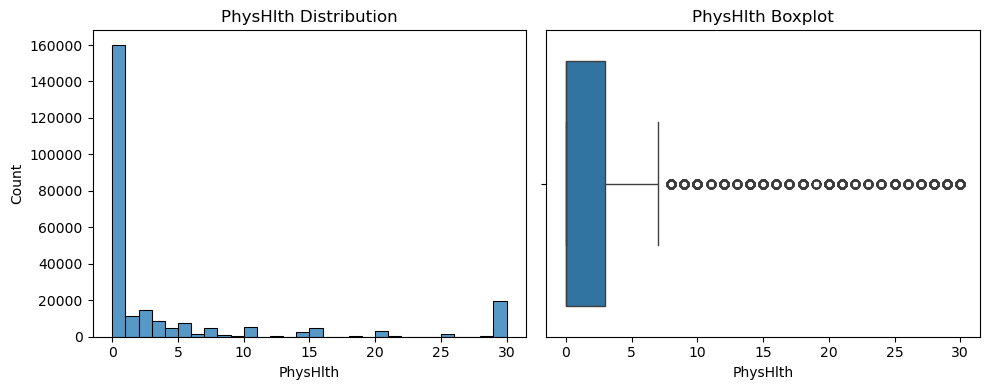

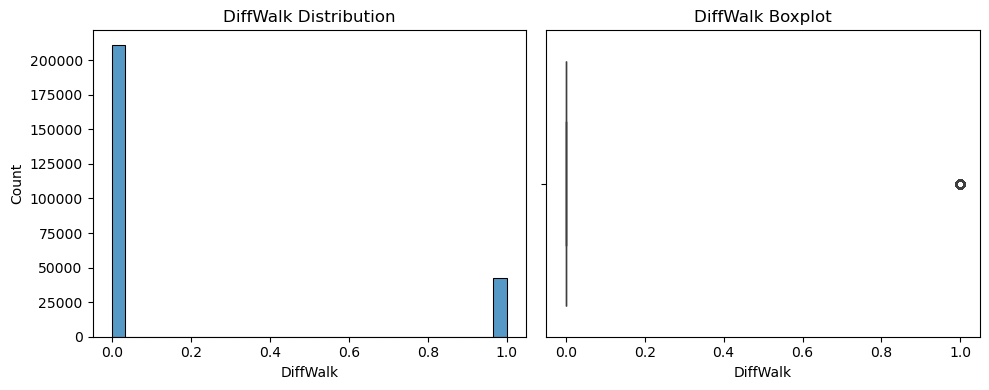

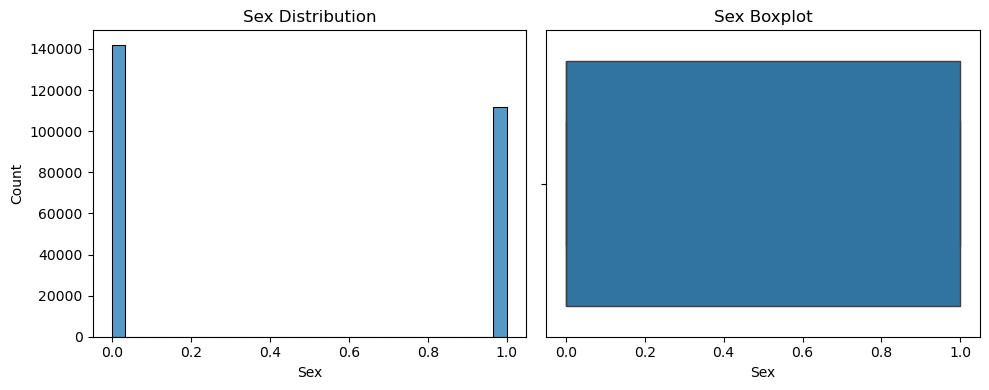

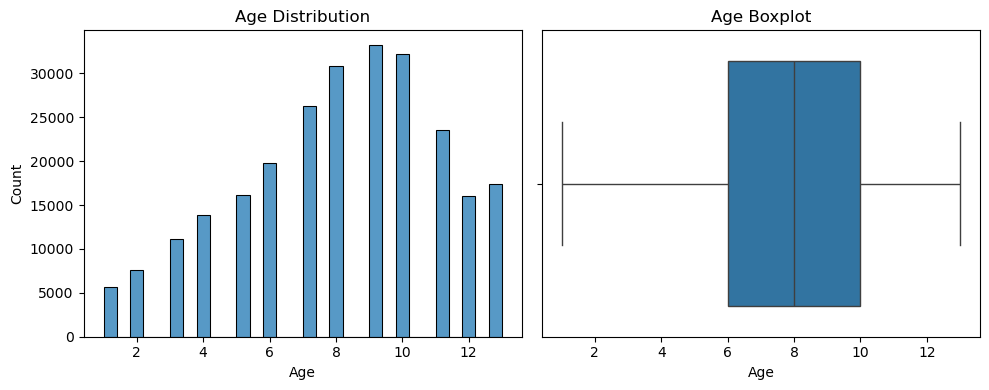

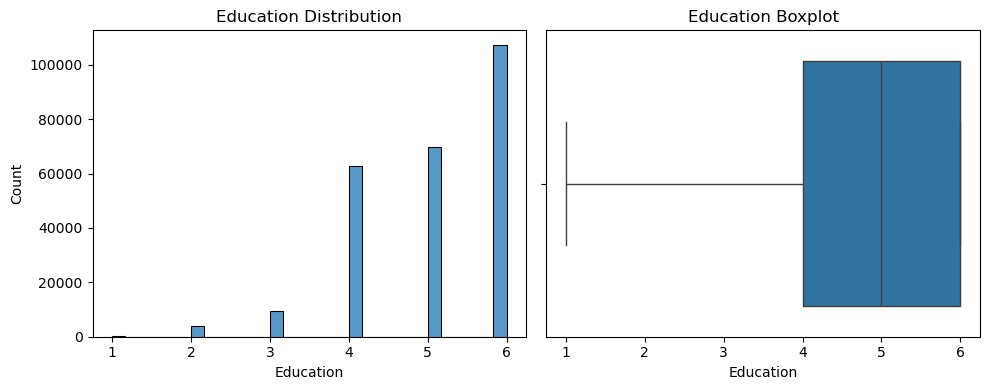

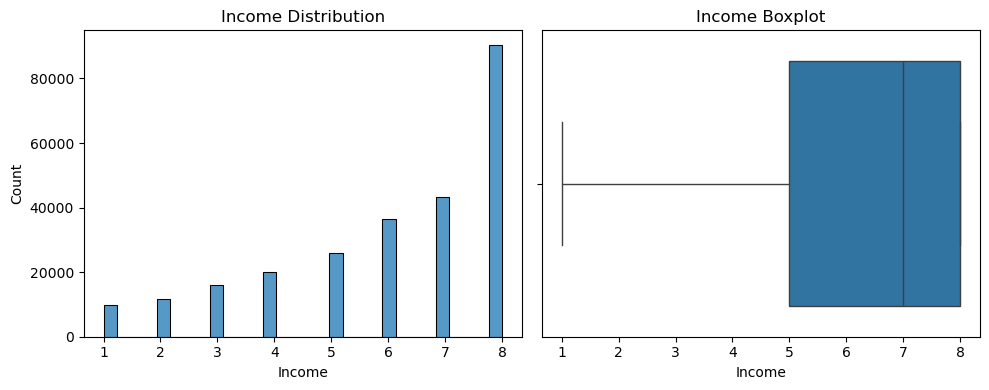

In [7]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
for feature in numerical_features:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], bins=30)
    plt.title(f'{feature} Distribution')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.title(f'{feature} Boxplot')

    plt.tight_layout()
    plt.show()


*These histograms and boxplots give us interesting insights on the features we'll work with. In general, we can already say that great part of the variables are either binary or divided in segments (for instance age, where the value of the record isn’t the actual age of that person, but a range where 1 is from 18 to 24 years old until 13 which is 80 years old or older; and each interval has a 5-year increment). We can also see many binary variables where there are much more records for one class than the other, or other non-binary variables with a high concentration of values in a certain range and some other outliers (which may be considered later)*

#### 2.4 CORRELATION MATRIX OF ALL FEATURES

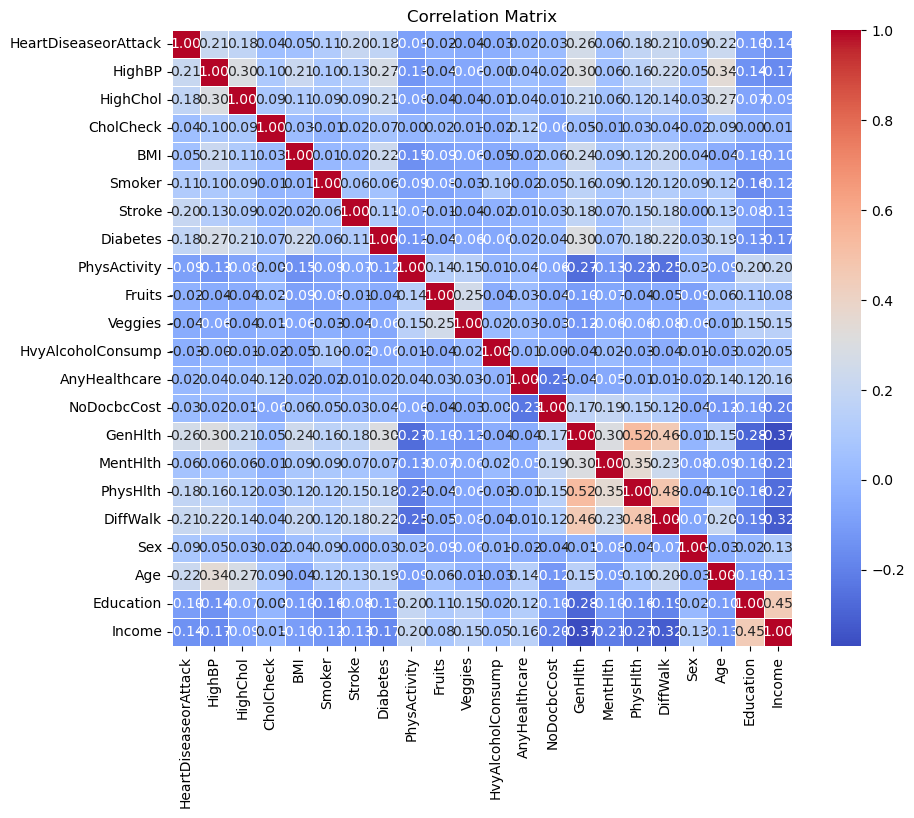

In [ ]:
corr_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

*We can't extract any strong correlations from the correlation matrix, all of them have quite low correlations.*

#### 2.5 2D PLOTS TO EXPLORE POSSIBLE RELATIONS BETWEEN VARIABLES

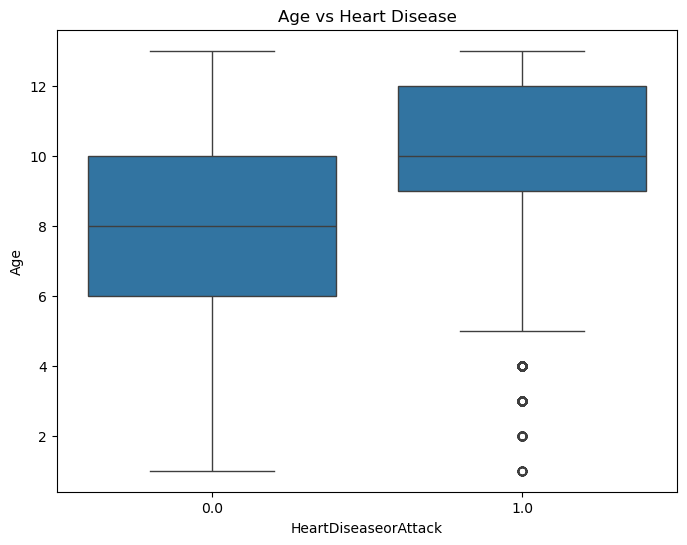

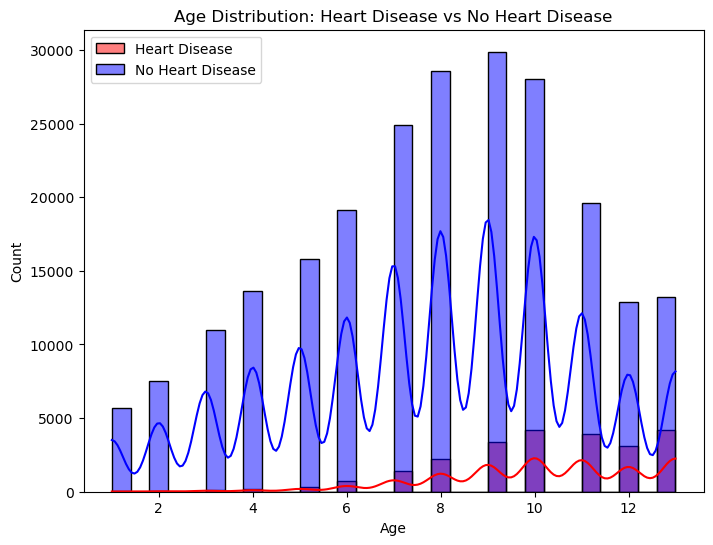

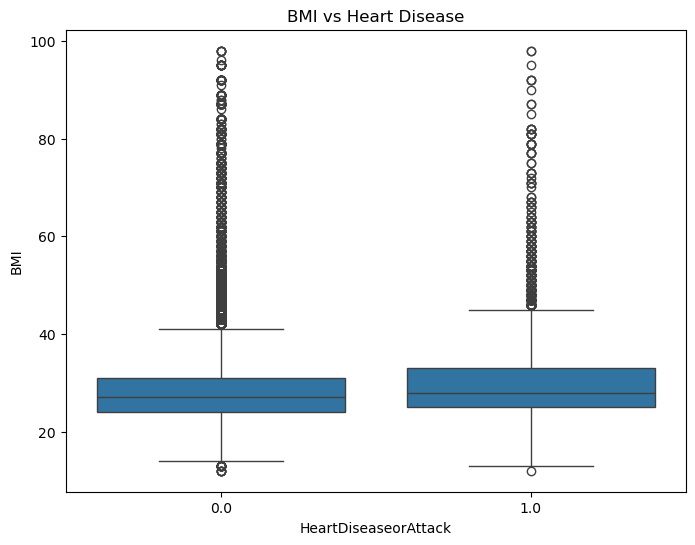

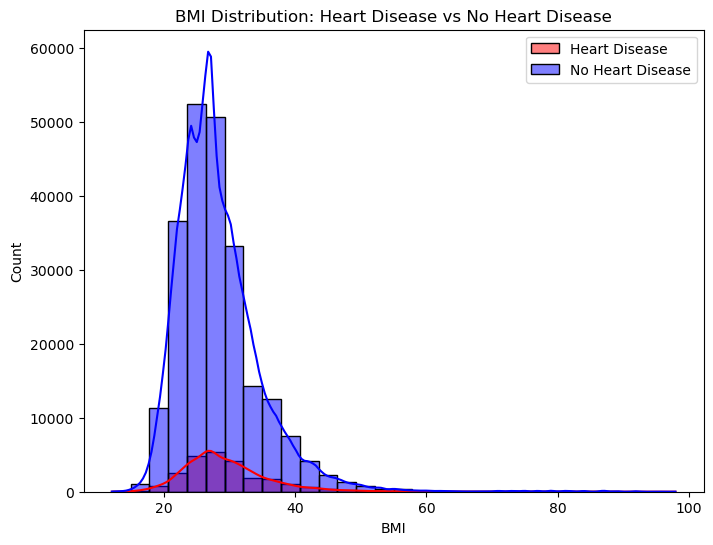

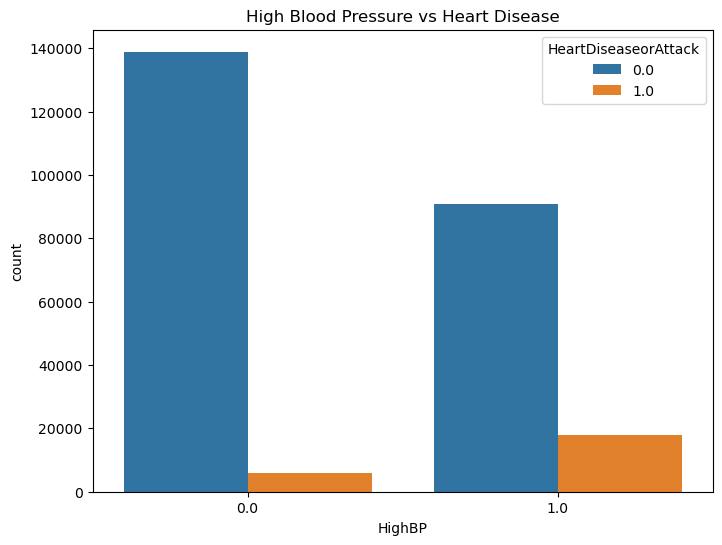

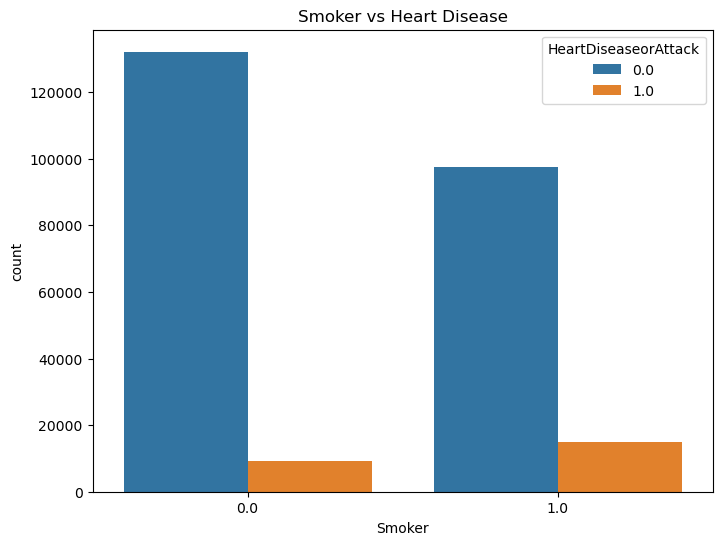

In [11]:
# Age distribution for HeartDiseaseorAttack
plt.figure(figsize=(8, 6))
sns.boxplot(x='HeartDiseaseorAttack', y='Age', data=df)
plt.title('Age vs Heart Disease')
plt.show()

# Distribution of Age for Heart Disease vs No Disease
plt.figure(figsize=(8, 6))
sns.histplot(df[df['HeartDiseaseorAttack'] == 1]['Age'], color='red', label='Heart Disease', kde=True, bins=30)
sns.histplot(df[df['HeartDiseaseorAttack'] == 0]['Age'], color='blue', label='No Heart Disease', kde=True, bins=30)
plt.title('Age Distribution: Heart Disease vs No Heart Disease')
plt.legend()
plt.show()

# Boxplot of BMI vs Heart Disease
plt.figure(figsize=(8, 6))
sns.boxplot(x='HeartDiseaseorAttack', y='BMI', data=df)
plt.title('BMI vs Heart Disease')
plt.show()

# BMI distribution for Heart Disease vs No Disease
plt.figure(figsize=(8, 6))
sns.histplot(df[df['HeartDiseaseorAttack'] == 1]['BMI'], color='red', label='Heart Disease', kde=True, bins=30)
sns.histplot(df[df['HeartDiseaseorAttack'] == 0]['BMI'], color='blue', label='No Heart Disease', kde=True, bins=30)
plt.title('BMI Distribution: Heart Disease vs No Heart Disease')
plt.legend()
plt.show()

# Check the distribution of HighBP in Heart Disease vs No Disease
plt.figure(figsize=(8, 6))
sns.countplot(x='HighBP', hue='HeartDiseaseorAttack', data=df)
plt.title('High Blood Pressure vs Heart Disease')
plt.show()

# Smoking vs Heart Disease
plt.figure(figsize=(8, 6))
sns.countplot(x='Smoker', hue='HeartDiseaseorAttack', data=df)
plt.title('Smoker vs Heart Disease')
plt.show()